In [1]:
import numpy as np
from utils import *
from mqt import qmap
from qiskit import *
from qiskit import IBMQ
import matplotlib.pyplot as plt
from IPython.display import display
from qiskit import QuantumCircuit, transpile
from sympy.utilities.iterables import multiset_permutations

In [2]:
IBMQ.save_account('de404b7eba21afacf3e900bcd1cc1244967cecad8f7051683e08ff88d444aee2e6cb029f51036d2eb8efd6f18bd04acf5d9bc0891891ebe4c1bb1ab062f7741b', overwrite=True)
IBMQ.load_account()

my_provider = IBMQ.get_provider()
backend  = my_provider.get_backend('ibmq_lima')

In [3]:
x_data0 = np.loadtxt('./Data/x_data0.txt', dtype=int)

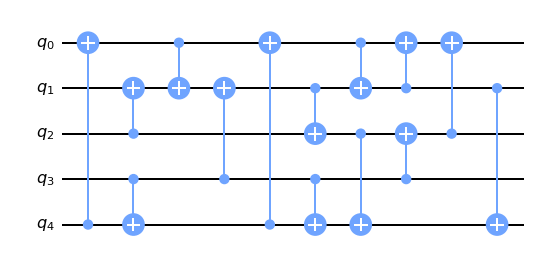

In [4]:
qc = random_circuit(num_qubits=5, depth=7)
qc.draw(output='mpl')

In [5]:
circ_mapped, results = qmap.compile(qc, backend, method="exact")
print(results.mapped_circuit)

// i 4 1 0 2 3
// o 4 1 3 2 0
OPENQASM 2.0;
include "qelib1.inc";
qreg q[5];
creg c[5];
cx q[3], q[4];
cx q[0], q[1];
swap q[1], q[3];
cx q[2], q[1];
cx q[4], q[3];
swap q[1], q[3];
cx q[2], q[1];
cx q[3], q[4];
swap q[1], q[3];
cx q[2], q[1];
swap q[0], q[1];
cx q[3], q[1];
cx q[4], q[3];
cx q[1], q[0];
cx q[2], q[1];
cx q[3], q[4];
swap q[1], q[3];
cx q[3], q[4];
cx q[1], q[0];
measure q[0] -> c[4];
measure q[1] -> c[1];
measure q[2] -> c[3];
measure q[3] -> c[2];
measure q[4] -> c[0];



In [6]:
def get_new_layout(qc, backend):
    circ_mapped, results = qmap.compile(qc, backend, method="exact")
    string = results.mapped_circuit
    l = len(string)
    
    for i in range(l):
        if(string[i]== 'i'):
            arr = string[i+2:i+12]
            break

    layout = []
    for i in range(len(arr)):
        if(arr[i] == ' '):
            continue
        else:
            layout.append(arr[i])

    layout.pop()
    return np.array(layout, dtype=int)

def get_key(val, dictionary):
    for key, value in dictionary.items():
        if (np.array_equal(val, value)):
            return key
    return "Key doesn't exist"

def get_encoded_target(layout, layoutdict):
    key = get_key(layout, layoutdict)
    encoded = np.zeros(120, dtype=int)
    encoded[key] = 1
    return encoded


def get_new_target_element(qc, layoutdict, backend):
    layout = get_new_layout(qc, backend)
    target = get_encoded_target(layout, layoutdict)
    
    return target

In [7]:
layout = get_new_layout(qc, backend)
print(layout)

[4 1 0 2 3]


In [8]:
layouts = np.array([0, 1, 2, 3, 4])
arr = []
for p in multiset_permutations(layouts):
    arr.append(p)
layoutdict = dict(enumerate(arr, 0))

In [9]:
print(get_encoded_target(layout, layoutdict))

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [10]:
#t = get_new_target_element(x_data0[0], layoutdict, backend)
#print(t)

In [11]:
def get_new_x_and_y_element(qubitno, layoutdict, backend):
    qc = random_circuit(num_qubits=qubitno, depth=random.randint(4,10))
    x_element = get_training_element(qc)
    y_element = get_new_target_element(qc=qc, layoutdict=layoutdict, backend=backend)
    return x_element, y_element

In [12]:
x, y = get_new_x_and_y_element(qubitno=5, layoutdict=layoutdict, backend=backend)
print(x)
print(y)

[4 2 3 1 4 0 3 1 0 1 3 4 2 4 1 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0]


In [13]:
def get_new_x_and_y_data(datasetsize, qubitno, layoutdict, backend):
    x_data = []
    y_data = []
    for i in range(datasetsize):
        x_element, y_element = get_new_x_and_y_element(qubitno, layoutdict, backend)
        x_data.append(x_element)
        y_data.append(y_element)
        if(i%500 == 0):
            print("Iteration", i)
        
    max_length = max(len(row) for row in x_data)
    x_data = np.array([np.pad(row, (0, max_length-len(row))) for row in x_data])
    y_data = np.array(y_data)
    
    return x_data, y_data

In [14]:
x, y = get_new_x_and_y_data(datasetsize=10000, qubitno=5, layoutdict=layoutdict, backend=backend)

Iteration 0
Iteration 500
Iteration 1000
Iteration 1500
Iteration 2000
Iteration 2500
Iteration 3000
Iteration 3500
Iteration 4000
Iteration 4500
Iteration 5000
Iteration 5500
Iteration 6000
Iteration 6500
Iteration 7000
Iteration 7500
Iteration 8000
Iteration 8500
Iteration 9000
Iteration 9500


In [15]:
np.savetxt('x_data0.txt', x, fmt='%d')
np.savetxt('y_data0.txt', y, fmt='%d')